Creating Dataset Class

In [2]:
import torch
import numpy as np
from transformers import BertTokenizer
import pandas as pd

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
labels = {'Financial Crime':0,
          'Cybercrime':1,
          'Drugs and Narcotics Trade':2,
          'Violent Crime':3,
          'Weapons Trade':4
          }

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, mode='head'):
        self.labels = [labels[label] for label in df['label']]
        self.texts = [text for text in df['text']]
        self.mode = mode

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        text = self.texts[idx]

        inputs = tokenizer(text, max_length=None, truncation=True, return_tensors="pt")
        return inputs

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        input_ids = batch_texts['input_ids']
        attention_mask = batch_texts['attention_mask']

        if input_ids.shape[1] > 512:
            if self.mode == 'head': #take the initial 512 tokens
                input_ids = input_ids[:, :512]
                attention_mask = attention_mask[:, :512]
            elif self.mode == 'tail': #take the last 512 tokens
                input_ids = input_ids[:, -512:]
                attention_mask = attention_mask[:, -512:]
            elif self.mode == 'middle':  #take the middle 512 tokens
                center = input_ids.shape[1] // 2
                input_ids = input_ids[:, center - 256:center + 256]
                attention_mask = attention_mask[:, center - 256:center + 256]
            else: #combine first 256 and last 256
                input_ids = torch.cat((input_ids[:, :256], input_ids[:, -256:]), dim=1)
                attention_mask = torch.cat((attention_mask[:, :256], attention_mask[:, -256:]), dim=1)

        #add padding manually
        if input_ids.shape[1] < 512:
            padding = torch.zeros(input_ids.shape[0], 512 - input_ids.shape[1])
            input_ids = torch.cat((input_ids, padding), dim=1)
            attention_mask = torch.cat((attention_mask, padding), dim=1)

        return {'input_ids': input_ids, 'attention_mask': attention_mask}, self.get_batch_labels(idx)




BERT Classifier with custom layers

In [3]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(model, dropout=0.1):

        super(BertClassifier, model).__init__()

        model.bert = BertModel.from_pretrained('bert-base-uncased')
        model.dropout = nn.Dropout(dropout) 
        model.linear = nn.Linear(768, 5)
        model.gelu = nn.GELU()

    def forward(model, input_id, mask):

        _, pooled_output = model.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = model.dropout(pooled_output)
        linear_output = model.linear(dropout_output)
        final_layer = model.gelu(linear_output)

        return final_layer

Training and evaluating functions

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, recall_score, f1_score
from torch.optim import AdamW

def train(model, train_data, val_data, learning_rate, epochs, plot_graphs=False, mode='combined', print_epochs=False, early_stop = True):
    train, val = Dataset(train_data, mode=mode), Dataset(val_data, mode=mode)
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=16, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=16)
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:2" if use_cuda else "cpu")
    model = model.to(device)  #move the model to the device
    if use_cuda and torch.cuda.device_count() > 1:
       model = torch.nn.DataParallel(model, device_ids=[2, 3])  #wrap the model to use 2 gpus


    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = AdamW(model.parameters(), lr=learning_rate)


    best_val_balanced_acc = 0
    num_epochs_no_improvement = 0

    train_losses = []
    val_losses = []
    train_balanced_accuracies = []  
    val_balanced_accuracies = []  

    for epoch_num in range(epochs):
        model.train()
        total_loss_train = 0
        y_true, y_pred = [], []

        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device, dtype=torch.long)
            input_id = train_input['input_ids'].squeeze(1).to(device, dtype=torch.long)

            output = model(input_id, mask)

            batch_loss = criterion(output, train_label.long())
            total_loss_train += batch_loss.item()

            _, predicted_labels = torch.max(output, dim=1)
            y_true.extend(train_label.cpu().numpy())
            y_pred.extend(predicted_labels.cpu().numpy())

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

        train_balanced_acc = balanced_accuracy_score(y_true, y_pred)
        train_losses.append(total_loss_train / len(train_data))
        train_balanced_accuracies.append(train_balanced_acc)

        model.eval()
        total_loss_val = 0
        y_true_val, y_pred_val = [], []

        with torch.no_grad():
            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device, dtype=torch.long)
                input_id = val_input['input_ids'].squeeze(1).to(device, dtype=torch.long)

                output = model(input_id, mask)

                batch_loss = criterion(output, val_label.long())
                total_loss_val += batch_loss.item()

                _, predicted_labels = torch.max(output, dim=1)
                y_true_val.extend(val_label.cpu().numpy())
                y_pred_val.extend(predicted_labels.cpu().numpy())

        val_balanced_acc = balanced_accuracy_score(y_true_val, y_pred_val)
        val_losses.append(total_loss_val / len(val_data))
        val_balanced_accuracies.append(val_balanced_acc)
    
        if print_epochs:
            print(f'Epochs: {epoch_num + 1} | Train Loss: {train_losses[-1]:.3f} '
                  f'| Train Balanced Accuracy: {train_balanced_acc:.3f} '
                  f'| Val Loss: {val_losses[-1]:.3f} '
                  f'| Val Balanced Accuracy: {val_balanced_acc:.3f}')
        
        if val_balanced_acc > best_val_balanced_acc:
            best_val_balanced_acc = val_balanced_acc
            num_epochs_no_improvement = 0
        else:
            num_epochs_no_improvement += 1
        
        if early_stop: #early stopping if no improvement for 3 epochs
            if num_epochs_no_improvement >= 3:
                print(f'Stopping at Epoch {epoch_num + 1}')
                epoch_stop = epoch_num + 1
                return epoch_stop

    if plot_graphs:
        #plot losses
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', color='blue')
        plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', color='orange')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Losses')
        plt.legend()
        plt.show()

        #plot balanced accuracies
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, epochs + 1), train_balanced_accuracies, label='Training Balanced Accuracy', color='blue')
        plt.plot(range(1, epochs + 1), val_balanced_accuracies, label='Validation Balanced Accuracy', color='orange')
        plt.xlabel('Epoch')
        plt.ylabel('Balanced Accuracy')
        plt.title('Training and Validation Balanced Accuracies')
        plt.legend()
        plt.show()


def evaluate(model, test_data,  mode='combined', metrics=False, save_pred = False):

    test = Dataset(test_data, mode=mode)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=16)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:2" if use_cuda else "cpu")
    model = model.to(device)  #move the model to the device
    if use_cuda and torch.cuda.device_count() > 1:
       model = torch.nn.DataParallel(model, device_ids=[2, 3])  #wrap the model


    model.eval()
    total_correct_by_class = [0] * len(labels)
    total_samples_by_class = [0] * len(labels)
    all_predictions = []
    all_labels = []

    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device, dtype=torch.long)
              input_id = test_input['input_ids'].squeeze(1).to(device, dtype=torch.long)

              output = model(input_id, mask)

              _, predicted_labels = torch.max(output, dim=1)

              all_predictions.extend(predicted_labels.cpu().numpy())
              all_labels.extend(test_label.cpu().numpy())
              

              for i in range(len(test_label)):
                  true_label = test_label[i].item()
                  predicted_label = predicted_labels[i].item()
                  total_samples_by_class[true_label] += 1
                  if true_label == predicted_label:
                      total_correct_by_class[true_label] += 1
    
    balanced_acc = balanced_accuracy_score(all_labels, all_predictions)
    #total_acc = accuracy_score(all_labels, all_predictions)
    if save_pred:
        output_df = pd.DataFrame({
        'true label': all_labels,
        'predicted label': all_predictions
        })
        output_filename = input("Enter the filename to save predictions (without extension): ")
        output_df.to_csv(f'{output_filename}.csv', index=False)
        
    if metrics:
        print(f'Balanced Accuracy: {balanced_acc:.5f}')
        #print(f'\nAccuracy: {total_acc:.5f}')

        class_recalls = recall_score(all_labels, all_predictions, labels=range(len(labels)), average=None)

        f1 = f1_score(all_labels, all_predictions, average='macro')

        print(f'F1 Score: {f1:.5f}\n')

        for i, label in enumerate(labels):
            class_recall = class_recalls[i]
            print(f'{label} Recall: {class_recall:.5f}\n')


        #confusion matrix
        conf_matrix = confusion_matrix(all_labels, all_predictions)
        conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
  
        labels_list = list(labels.keys())
        conf_df = pd.DataFrame(conf_matrix, index=labels_list, columns=labels_list)

        #heatmap
        plt.figure(figsize=(10, 7))
        cmap = sns.diverging_palette(220, 20, as_cmap=True)
        sns.heatmap(conf_matrix_norm, annot=conf_df, fmt='d', cmap=cmap, cbar_kws={'label': 'Percentage'})
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.xticks(np.arange(len(labels_list))+0.5, labels_list, rotation=45)
        plt.yticks(np.arange(len(labels_list))+0.5, labels_list, rotation=0)

        plt.show()

    else:
        return balanced_acc #returns balanced accuracy for hyperparameter tuning



Datasets

Train test split before lowercasing --> for data augmentation

In [ ]:
#Train\val\test split is performed before the augmentation, stratified with 60-20-20 proportion.
df_trainval = pd.read_csv('data/trainval.csv', index_col= 0)
df_train = pd.read_csv('data/train.csv', index_col= 0)
df_test = pd.read_csv('data/test.csv', index_col=0)
df_val = pd.read_csv('data/val.csv', index_col=0)

#Lowercasing
df_train['text'] = df_train['text'].apply(lambda x: x.lower())
df_trainval['text'] = df_trainval['text'].apply(lambda x: x.lower())
df_test['text'] = df_test['text'].apply(lambda x: x.lower())
df_val['text'] = df_val['text'].apply(lambda x: x.lower())

print(df_train.shape, df_trainval.shape, df_val.shape, df_test.shape)

Class distribution

In [5]:
df_trainval.groupby('label').count()
#Augmented trainval set needs CC 155, DN 275, WT 535, VC 575

,domain_id,page_id,snapshot_id,tags,text,text_len
label,,,,,,
Cybercrime,462,462,462,462,462,462
Drugs and Narcotics Trade,342,342,342,342,342,342
Financial Crime,617,617,617,617,617,617
Violent Crime,42,42,42,42,42,42
Weapons Trade,82,82,82,82,82,82


In [6]:
df_train.groupby('label').count()
#Augmented train set needs CC 116, DN 206, WT 400, VC 430

,domain_id,page_id,snapshot_id,tags,text,text_len
label,,,,,,
Cybercrime,346,346,346,346,346,346
Drugs and Narcotics Trade,256,256,256,256,256,256
Financial Crime,462,462,462,462,462,462
Violent Crime,32,32,32,32,32,32
Weapons Trade,62,62,62,62,62,62


Hyperparameters tuning

In [12]:
import itertools
import pickle
import torch

#Functions to save and load existing results so the process can be interrupted and resumed at any time
def save_results(result, results_file):
    existing_results = load_results(results_file)
    existing_results.append(result)
    with open(results_file, 'wb') as f:
        pickle.dump(existing_results, f)

def load_results(results_file):
    try:
        with open(results_file, 'rb') as f:
            existing_results = pickle.load(f)
        return existing_results
    except FileNotFoundError:
        return []
    
def train_and_evaluate(model, lr, dropout, mode, train_data, val_data):
    model.train()
    epoch_num = train(model, train_data, val_data, lr, epochs=10, mode=mode, plot_graphs=False)

    model.eval()
    with torch.no_grad():
        balanced_acc = evaluate(model, val_data, mode=mode)

    return {'lr': lr, 'dropout': dropout, 'epochs': epoch_num, 'mode': mode, 'balanced_acc': balanced_acc}

def grid_search(param_grid, train_data, val_data, results_file):
    #Loading existing results
    existing_results = load_results(results_file)

    #initializing best_score and best_params with values from existing results, if available
    best_score = 0
    best_params = {}
    for result in existing_results:
        try:
            score = result['balanced_acc']
            if score > best_score:
                best_score = score
                best_params = {'lr': result['lr'], 'dropout': result['dropout'], 'epochs': result['epochs'], 'mode': result['mode']}
        except (KeyError, TypeError):
            #handles errors
            pass

    #initializing processed_combinations set with combinations from existing results
    processed_combinations = set()
    for result in existing_results:
        try:
            combination = (result['lr'], result['dropout'], result['mode'])
            processed_combinations.add(combination)
        except (KeyError, TypeError):
            pass

    #Continue with the search
    combinations = itertools.product(param_grid['lr'], param_grid['dropout'], param_grid['mode'])
    for lr, dropout, mode in combinations:
        if (lr, dropout, mode) in processed_combinations:
            #Skip already processed combinations
            continue

        print(f"Processing combination: lr={lr}, dropout={dropout}, mode={mode}")

        model = BertClassifier(dropout=dropout)

        result = train_and_evaluate(model, lr, dropout, mode, train_data, val_data)

        save_results(result, results_file)

        if result['balanced_acc'] > best_score:
            best_score = result['balanced_acc']
            best_params = {'lr': lr, 'dropout': dropout, 'epochs': result['epochs'], 'mode': mode}

    return best_params, best_score


param_grid = {'lr': [5e-5, 4e-5, 3e-5, 2e-5], 'dropout': [0.1, 0.3, 0.5], 'mode': ['head', 'tail', 'combined']}
results_file = 'grid_search_result.pkl'


In [13]:
#Run or continue the grid search
best_params, best_score = grid_search(param_grid, df_train, df_val, results_file)

print(f'Best Hyperparameters: {best_params}')
print(f'Best Balanced Accuracy: {best_score:.5f}')



Best Hyperparameters: {'lr': 4e-05, 'dropout': 0.3, 'epochs': 10, 'mode': 'head'}
Best Balanced Accuracy: 0.94359


In [14]:
existing_results = load_results('grid_search_result.pkl')

for result in existing_results:
    lr, dropout, mode = result['lr'], result['dropout'], result['mode']
    balanced_acc = result['balanced_acc']
    print(f"Combination --> lr={lr}, dropout={dropout}, mode={mode}, balanced accuracy: {balanced_acc:.3f}")
#Displaying all results

Combination --> lr=5e-05, dropout=0.1, mode=head, balanced accuracy: 0.920
Combination --> lr=5e-05, dropout=0.1, mode=tail, balanced accuracy: 0.942
Combination --> lr=5e-05, dropout=0.1, mode=combined, balanced accuracy: 0.935
Combination --> lr=5e-05, dropout=0.3, mode=head, balanced accuracy: 0.943
Combination --> lr=5e-05, dropout=0.3, mode=tail, balanced accuracy: 0.919
Combination --> lr=5e-05, dropout=0.3, mode=combined, balanced accuracy: 0.933
Combination --> lr=5e-05, dropout=0.5, mode=head, balanced accuracy: 0.916
Combination --> lr=5e-05, dropout=0.5, mode=tail, balanced accuracy: 0.923
Combination --> lr=5e-05, dropout=0.5, mode=combined, balanced accuracy: 0.938
Combination --> lr=4e-05, dropout=0.1, mode=head, balanced accuracy: 0.939
Combination --> lr=4e-05, dropout=0.1, mode=tail, balanced accuracy: 0.910
Combination --> lr=4e-05, dropout=0.1, mode=combined, balanced accuracy: 0.924
Combination --> lr=4e-05, dropout=0.3, mode=head, balanced accuracy: 0.944
Combinati

In [15]:
sorted_results = sorted(existing_results, key=lambda x: x['balanced_acc'], reverse=True)
for i in range(5): #Can change to any top x
    result = sorted_results[i]
    lr, dropout, mode = result['lr'], result['dropout'], result['mode']
    balanced_acc = result['balanced_acc']
    print(f"Top {i+1} --> Combination: lr={lr}, dropout={dropout}, mode={mode}, Balanced Accuracy: {balanced_acc:.3f}")
#Displaying top 5 results

Top 1 --> Combination: lr=4e-05, dropout=0.3, mode=head, Balanced Accuracy: 0.944
Top 2 --> Combination: lr=5e-05, dropout=0.3, mode=head, Balanced Accuracy: 0.943
Top 3 --> Combination: lr=5e-05, dropout=0.1, mode=tail, Balanced Accuracy: 0.942
Top 4 --> Combination: lr=3e-05, dropout=0.1, mode=head, Balanced Accuracy: 0.941
Top 5 --> Combination: lr=2e-05, dropout=0.3, mode=tail, Balanced Accuracy: 0.941


Temperature tuning - Exploration of temperature value with tuned hyperparameters

In [16]:
augmented_03temp = pd.read_csv('data/augmented_03temp_4bit.csv', index_col=0)
df_aug_temp_3_4bit = pd.concat([df_train[['text', 'label','snapshot_id']], augmented_03temp], ignore_index=True) 
df_aug_temp_3_4bit['text'] = df_aug_temp_3_4bit['text'].apply(lambda x: x.lower())

In [17]:
df_aug_temp_3_4bit.groupby('label').count()

,text,snapshot_id
label,,
Cybercrime,462,462
Drugs and Narcotics Trade,462,462
Financial Crime,462,462
Violent Crime,462,462
Weapons Trade,462,462


In [18]:
augmented_08temp = pd.read_csv('data/augmented_08temp_4bit.csv', index_col=0)
df_aug_temp_8_4bit = pd.concat([df_train[['text', 'label','snapshot_id']], augmented_08temp], ignore_index=True) 
df_aug_temp_8_4bit['text'] = df_aug_temp_8_4bit['text'].apply(lambda x: x.lower())

In [19]:
df_aug_temp_8_4bit.groupby('label').count()

,text,snapshot_id
label,,
Cybercrime,462,462
Drugs and Narcotics Trade,462,462
Financial Crime,462,462
Violent Crime,462,462
Weapons Trade,462,462


Best Hyperparameters: {'lr': 4e-05, 'dropout': 0.3, 'epochs': 10, 'mode': 'head'}

In [20]:
EPOCHS = 10
model = BertClassifier(dropout= 0.3)
LR = 4e-05
mode = 'head'

In [21]:
train(model, df_aug_temp_3_4bit, df_val, LR, EPOCHS, mode=mode, early_stop=True)

100%|██████████| 145/145 [00:56<00:00,  2.55it/s]


Stopping at Epoch 10


10

In [22]:
evaluate(model, df_val, mode=mode)

0.9230615412473808

In [23]:
EPOCHS = 10
model = BertClassifier(dropout= 0.3)
LR = 4e-05
mode = 'head'

In [24]:
train(model, df_aug_temp_8_4bit, df_val, LR, EPOCHS, mode=mode, early_stop=True)

100%|██████████| 145/145 [00:56<00:00,  2.56it/s]


Stopping at Epoch 6


6

In [25]:
evaluate(model, df_val, mode=mode)

0.9314382906071346

In [26]:
EPOCHS = 10
model = BertClassifier(dropout= 0.3)
LR = 4e-05
mode = 'head'

In [27]:
train(model, df_train, df_val, LR, EPOCHS, mode=mode, early_stop=True)

100%|██████████| 73/73 [00:32<00:00,  2.27it/s]


Stopping at Epoch 7


7

In [28]:
evaluate(model, df_val, mode=mode)

0.9204705486716506

Selected temperature based on Balanced Accuracy = 0.8

LLaMA2 Augmented Dataset

In [14]:
augmented_train = pd.read_csv('data/augmented_train.csv', index_col=0)
df_aug_train = pd.concat([augmented_train, df_train[['text', 'snapshot_id', 'label']]], ignore_index=True)
df_aug_train['text'] = df_aug_train['text'].apply(lambda x: x.lower())

In [15]:
augmented_trainval = pd.read_csv('data/augmented_trainval.csv', index_col=0)
df_aug_trainval = pd.concat([augmented_trainval, df_trainval[['text', 'snapshot_id', 'label']]], ignore_index=True)
df_aug_trainval['text'] = df_aug_trainval['text'].apply(lambda x: x.lower())

In [16]:
df_aug_train.groupby('label').count()

,text,snapshot_id
label,,
Cybercrime,462,462
Drugs and Narcotics Trade,462,462
Financial Crime,462,462
Violent Crime,462,462
Weapons Trade,462,462


In [17]:
df_aug_trainval.groupby('label').count()

,text,snapshot_id
label,,
Cybercrime,617,617
Drugs and Narcotics Trade,617,617
Financial Crime,617,617
Violent Crime,617,617
Weapons Trade,617,617


Undersampled dataset

In [18]:
from imblearn.under_sampling import RandomUnderSampler
under = RandomUnderSampler(sampling_strategy="not minority", random_state=38) 
                     
df_under_train, _ = under.fit_resample(df_train, df_train[["label"]])
df_under_train.groupby('label').count()

,domain_id,page_id,snapshot_id,tags,text,text_len
label,,,,,,
Cybercrime,32,32,32,32,32,32
Drugs and Narcotics Trade,32,32,32,32,32,32
Financial Crime,32,32,32,32,32,32
Violent Crime,32,32,32,32,32,32
Weapons Trade,32,32,32,32,32,32


In [19]:
df_under_trainval, _ = under.fit_resample(df_trainval, df_trainval[["label"]])
df_under_trainval.groupby('label').count()

,domain_id,page_id,snapshot_id,tags,text,text_len
label,,,,,,
Cybercrime,42,42,42,42,42,42
Drugs and Narcotics Trade,42,42,42,42,42,42
Financial Crime,42,42,42,42,42,42
Violent Crime,42,42,42,42,42,42
Weapons Trade,42,42,42,42,42,42


Comparing the approaches

Baseline

In [20]:
EPOCHS = 10
model = BertClassifier(dropout= 0.3)
LR = 4e-05
mode = 'head'

#Combination --> lr=4e-05, dropout=0.3, mode=head, balanced accuracy: 0.944

100%|██████████| 73/73 [00:34<00:00,  2.13it/s]


Epochs: 1 | Train Loss: 0.049 | Train Balanced Accuracy: 0.550 | Val Loss: 0.024 | Val Balanced Accuracy: 0.706


100%|██████████| 73/73 [00:32<00:00,  2.27it/s]


Epochs: 2 | Train Loss: 0.020 | Train Balanced Accuracy: 0.873 | Val Loss: 0.017 | Val Balanced Accuracy: 0.945


100%|██████████| 73/73 [00:32<00:00,  2.26it/s]


Epochs: 3 | Train Loss: 0.014 | Train Balanced Accuracy: 0.947 | Val Loss: 0.017 | Val Balanced Accuracy: 0.940


100%|██████████| 73/73 [00:32<00:00,  2.27it/s]


Epochs: 4 | Train Loss: 0.011 | Train Balanced Accuracy: 0.947 | Val Loss: 0.017 | Val Balanced Accuracy: 0.943


100%|██████████| 73/73 [00:32<00:00,  2.28it/s]


Epochs: 5 | Train Loss: 0.009 | Train Balanced Accuracy: 0.950 | Val Loss: 0.017 | Val Balanced Accuracy: 0.937


100%|██████████| 73/73 [00:32<00:00,  2.27it/s]


Epochs: 6 | Train Loss: 0.009 | Train Balanced Accuracy: 0.953 | Val Loss: 0.019 | Val Balanced Accuracy: 0.945


100%|██████████| 73/73 [00:32<00:00,  2.27it/s]


Epochs: 7 | Train Loss: 0.006 | Train Balanced Accuracy: 0.965 | Val Loss: 0.021 | Val Balanced Accuracy: 0.918


100%|██████████| 73/73 [00:32<00:00,  2.26it/s]


Epochs: 8 | Train Loss: 0.004 | Train Balanced Accuracy: 0.971 | Val Loss: 0.021 | Val Balanced Accuracy: 0.932


100%|██████████| 73/73 [00:32<00:00,  2.27it/s]


Epochs: 9 | Train Loss: 0.004 | Train Balanced Accuracy: 0.973 | Val Loss: 0.026 | Val Balanced Accuracy: 0.929


100%|██████████| 73/73 [00:32<00:00,  2.26it/s]


Epochs: 10 | Train Loss: 0.006 | Train Balanced Accuracy: 0.965 | Val Loss: 0.023 | Val Balanced Accuracy: 0.918


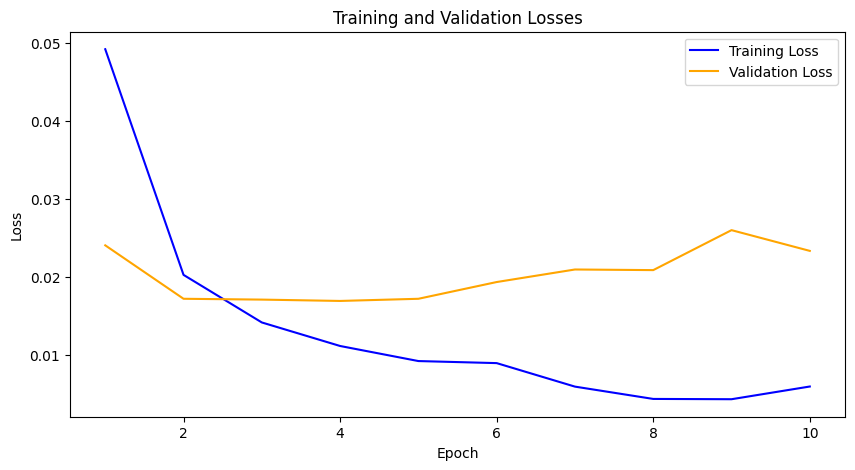

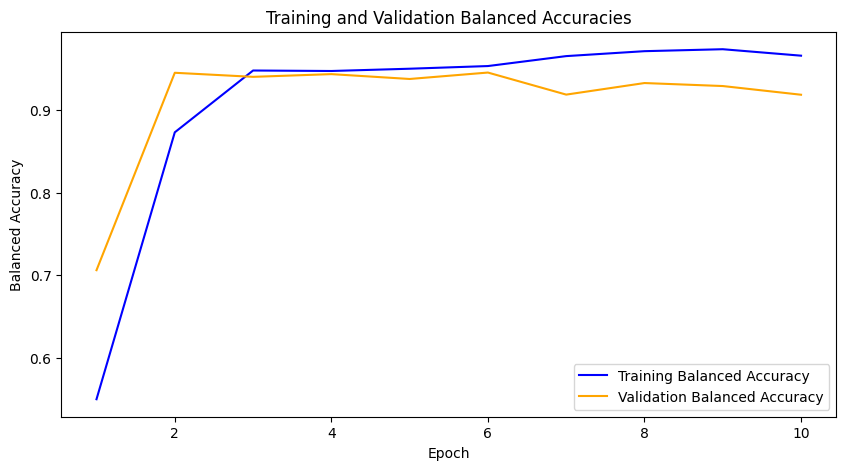

In [ ]:
train(model, df_train, df_val, LR, EPOCHS, mode=mode, plot_graphs=True, print_epochs=True, early_stop=False)

In [23]:
EPOCHS = 2
model = BertClassifier(dropout= 0.3)
LR = 4e-05
mode = 'head'

In [24]:
train(model, df_trainval, df_test, LR, EPOCHS, mode=mode, early_stop=False)

  0%|          | 0/97 [00:00<?, ?it/s]

100%|██████████| 97/97 [00:42<00:00,  2.27it/s]


Balanced Accuracy: 0.91358
F1 Score: 0.92705

Financial Crime Recall: 0.90909

Cybercrime Recall: 0.93966

Drugs and Narcotics Trade Recall: 0.95294

Violent Crime Recall: 0.90909

Weapons Trade Recall: 0.85714



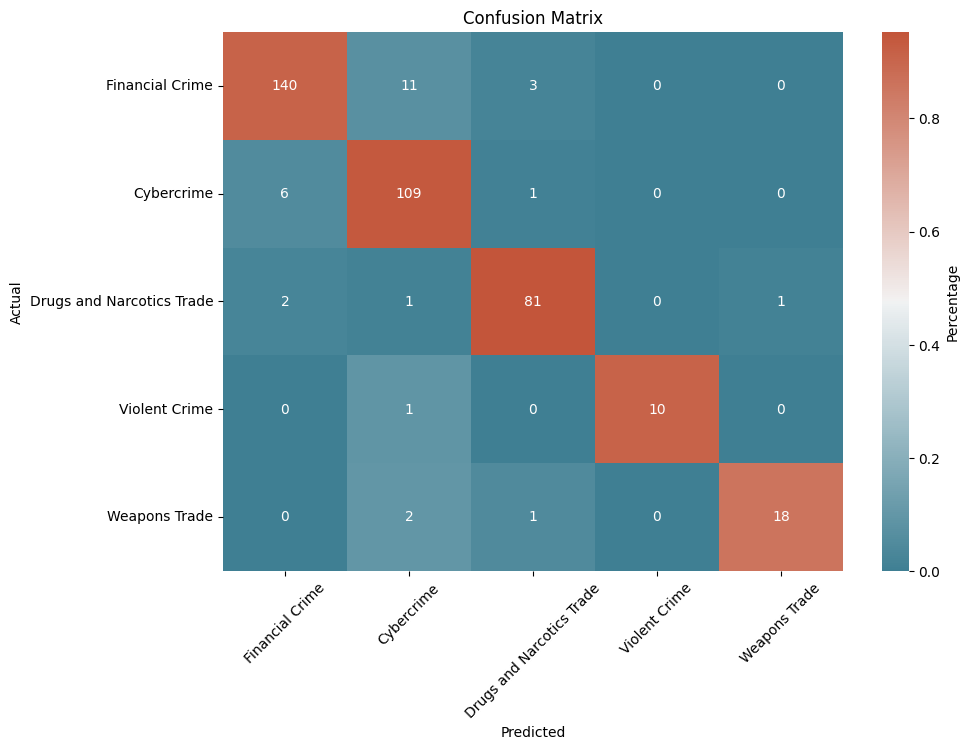

In [25]:
evaluate(model, df_test, mode=mode, metrics=True) 

In [ ]:
#Sensitivity to text length : BERT_middle

In [13]:
EPOCHS = 2
model = BertClassifier(dropout= 0.3)
LR = 4e-05
mode = 'head'

In [14]:
train(model, df_trainval, df_test, LR, EPOCHS, mode=mode, early_stop=False)

  0%|          | 0/97 [00:00<?, ?it/s]

100%|██████████| 97/97 [00:42<00:00,  2.28it/s]


Balanced Accuracy: 0.91450
F1 Score: 0.93434

Financial Crime Recall: 0.92857

Cybercrime Recall: 0.94828

Drugs and Narcotics Trade Recall: 0.92941

Violent Crime Recall: 0.90909

Weapons Trade Recall: 0.85714



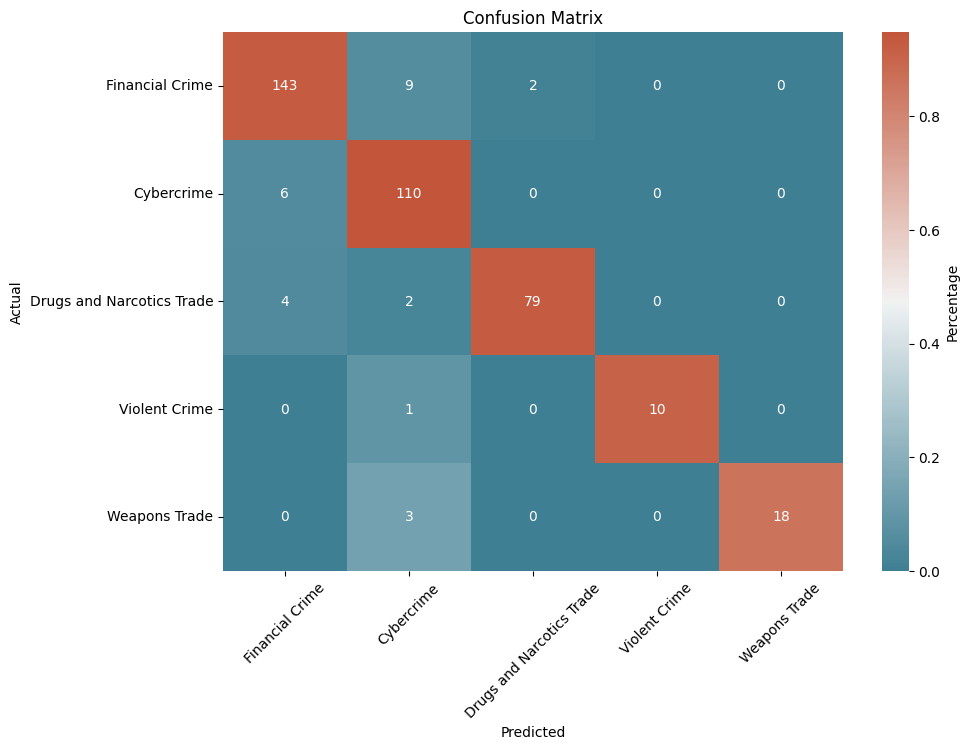

In [15]:
evaluate(model, df_test, mode='middle', metrics=True) #part of error analysis

Undersampling

In [26]:
EPOCHS = 10
model = BertClassifier(dropout= 0.3)
LR = 4e-05
mode = 'head'

100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


Epochs: 1 | Train Loss: 0.102 | Train Balanced Accuracy: 0.206 | Val Loss: 0.109 | Val Balanced Accuracy: 0.340


100%|██████████| 10/10 [00:08<00:00,  1.25it/s]


Epochs: 2 | Train Loss: 0.100 | Train Balanced Accuracy: 0.281 | Val Loss: 0.106 | Val Balanced Accuracy: 0.380


100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


Epochs: 3 | Train Loss: 0.091 | Train Balanced Accuracy: 0.500 | Val Loss: 0.080 | Val Balanced Accuracy: 0.758


100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


Epochs: 4 | Train Loss: 0.062 | Train Balanced Accuracy: 0.744 | Val Loss: 0.051 | Val Balanced Accuracy: 0.865


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


Epochs: 5 | Train Loss: 0.033 | Train Balanced Accuracy: 0.912 | Val Loss: 0.033 | Val Balanced Accuracy: 0.896


100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


Epochs: 6 | Train Loss: 0.019 | Train Balanced Accuracy: 0.950 | Val Loss: 0.026 | Val Balanced Accuracy: 0.903


100%|██████████| 10/10 [00:07<00:00,  1.25it/s]


Epochs: 7 | Train Loss: 0.011 | Train Balanced Accuracy: 0.969 | Val Loss: 0.030 | Val Balanced Accuracy: 0.897


100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


Epochs: 8 | Train Loss: 0.008 | Train Balanced Accuracy: 0.981 | Val Loss: 0.034 | Val Balanced Accuracy: 0.870


100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


Epochs: 9 | Train Loss: 0.005 | Train Balanced Accuracy: 0.988 | Val Loss: 0.028 | Val Balanced Accuracy: 0.906


100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


Epochs: 10 | Train Loss: 0.004 | Train Balanced Accuracy: 0.988 | Val Loss: 0.028 | Val Balanced Accuracy: 0.909


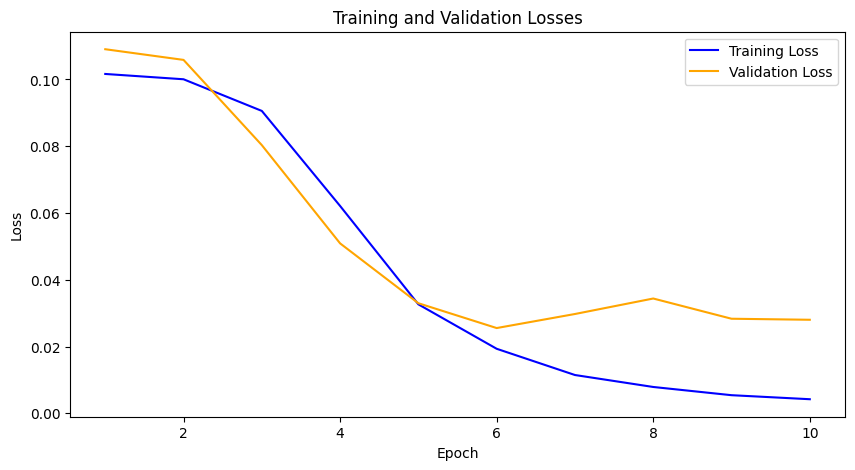

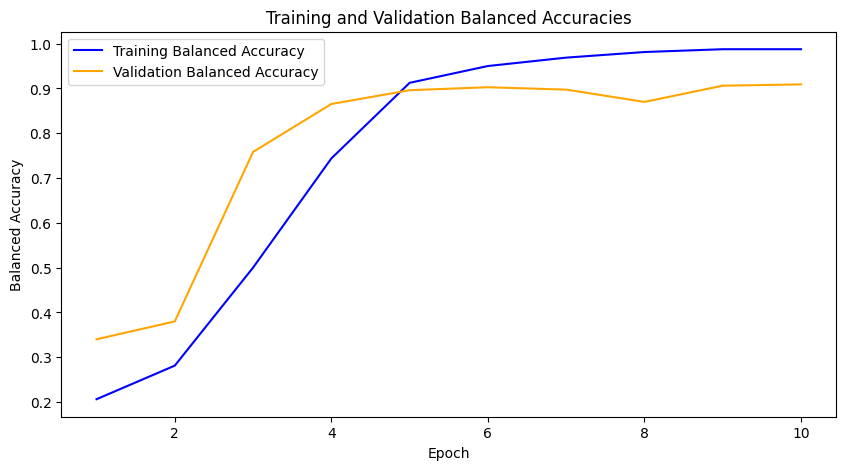

In [27]:
train(model, df_under_train, df_val, LR, EPOCHS,mode=mode, early_stop=False, print_epochs=True, plot_graphs=True)

In [25]:
EPOCHS = 6
model = BertClassifier(dropout= 0.3)
LR = 4e-05
mode = 'head'

In [26]:
train(model, df_under_trainval, df_test, LR, EPOCHS,mode=mode, early_stop=False)

100%|██████████| 14/14 [00:06<00:00,  2.20it/s]


Balanced Accuracy: 0.88773
F1 Score: 0.87648

Financial Crime Recall: 0.82468

Cybercrime Recall: 0.87069

Drugs and Narcotics Trade Recall: 0.92941

Violent Crime Recall: 0.90909

Weapons Trade Recall: 0.90476



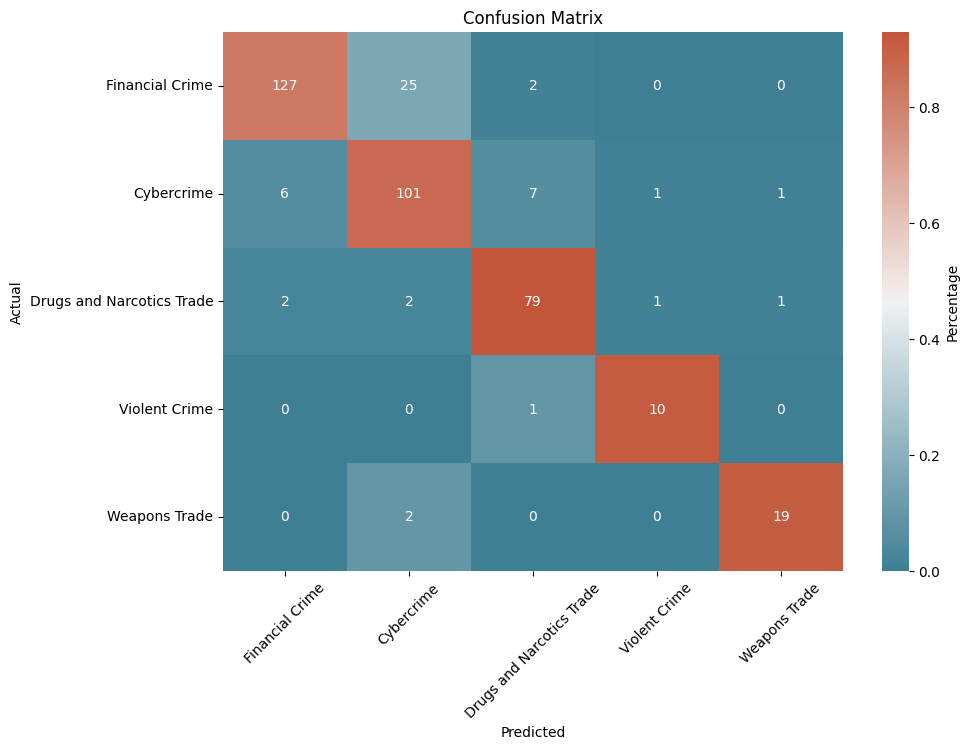

In [27]:
evaluate(model, df_test, mode=mode, metrics=True)

Augmented Dataset

In [31]:
EPOCHS = 10
model = BertClassifier(dropout= 0.3)
LR = 4e-05
mode = 'head'

100%|██████████| 145/145 [01:44<00:00,  1.38it/s]


Epochs: 1 | Train Loss: 0.048 | Train Balanced Accuracy: 0.749 | Val Loss: 0.026 | Val Balanced Accuracy: 0.922


100%|██████████| 145/145 [01:39<00:00,  1.45it/s]


Epochs: 2 | Train Loss: 0.022 | Train Balanced Accuracy: 0.900 | Val Loss: 0.019 | Val Balanced Accuracy: 0.935


100%|██████████| 145/145 [01:42<00:00,  1.42it/s]


Epochs: 3 | Train Loss: 0.014 | Train Balanced Accuracy: 0.942 | Val Loss: 0.018 | Val Balanced Accuracy: 0.932


100%|██████████| 145/145 [01:41<00:00,  1.42it/s]


Epochs: 4 | Train Loss: 0.011 | Train Balanced Accuracy: 0.958 | Val Loss: 0.021 | Val Balanced Accuracy: 0.897


100%|██████████| 145/145 [01:45<00:00,  1.38it/s]


Epochs: 5 | Train Loss: 0.008 | Train Balanced Accuracy: 0.972 | Val Loss: 0.020 | Val Balanced Accuracy: 0.944


100%|██████████| 145/145 [01:38<00:00,  1.47it/s]


Epochs: 6 | Train Loss: 0.005 | Train Balanced Accuracy: 0.980 | Val Loss: 0.023 | Val Balanced Accuracy: 0.924


100%|██████████| 145/145 [01:35<00:00,  1.53it/s]


Epochs: 7 | Train Loss: 0.005 | Train Balanced Accuracy: 0.981 | Val Loss: 0.024 | Val Balanced Accuracy: 0.922


100%|██████████| 145/145 [00:55<00:00,  2.61it/s]


Epochs: 8 | Train Loss: 0.004 | Train Balanced Accuracy: 0.987 | Val Loss: 0.022 | Val Balanced Accuracy: 0.942


100%|██████████| 145/145 [00:55<00:00,  2.60it/s]


Epochs: 9 | Train Loss: 0.005 | Train Balanced Accuracy: 0.982 | Val Loss: 0.027 | Val Balanced Accuracy: 0.921


100%|██████████| 145/145 [00:55<00:00,  2.60it/s]


Epochs: 10 | Train Loss: 0.004 | Train Balanced Accuracy: 0.985 | Val Loss: 0.028 | Val Balanced Accuracy: 0.915


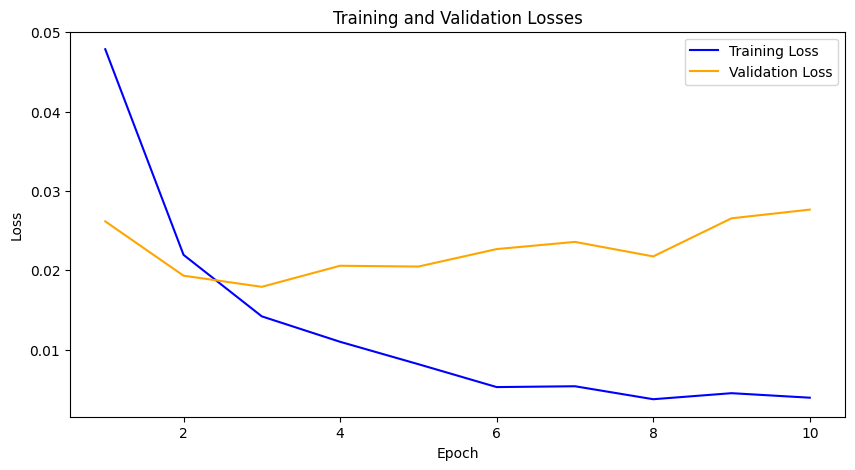

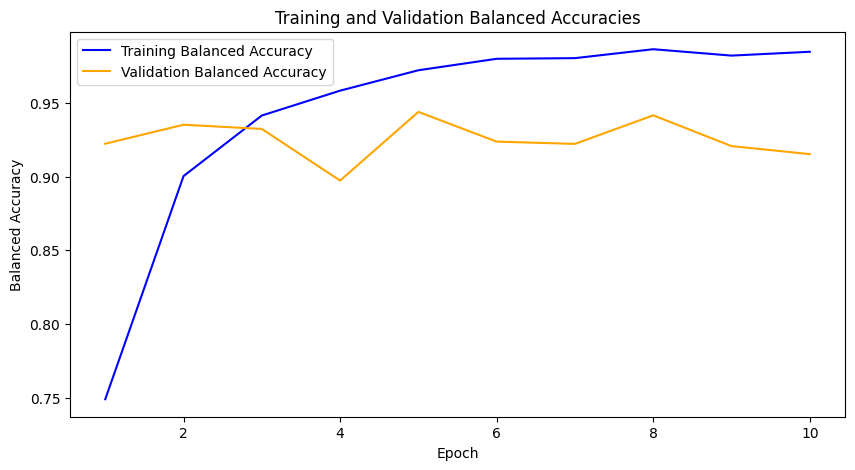

In [32]:
train(model, df_aug_train, df_val, LR, EPOCHS, mode=mode, plot_graphs=True, early_stop=False, print_epochs=True)

In [36]:
EPOCHS = 2
model = BertClassifier(dropout= 0.3)
LR = 4e-05
mode = 'head'

In [37]:
train(model, df_aug_trainval, df_test, LR, EPOCHS, mode=mode, early_stop=False)

100%|██████████| 193/193 [01:14<00:00,  2.58it/s]


Balanced Accuracy: 0.92789
F1 Score: 0.93749

Financial Crime Recall: 0.91558

Cybercrime Recall: 0.91379

Drugs and Narcotics Trade Recall: 0.95294

Violent Crime Recall: 1.00000

Weapons Trade Recall: 0.85714



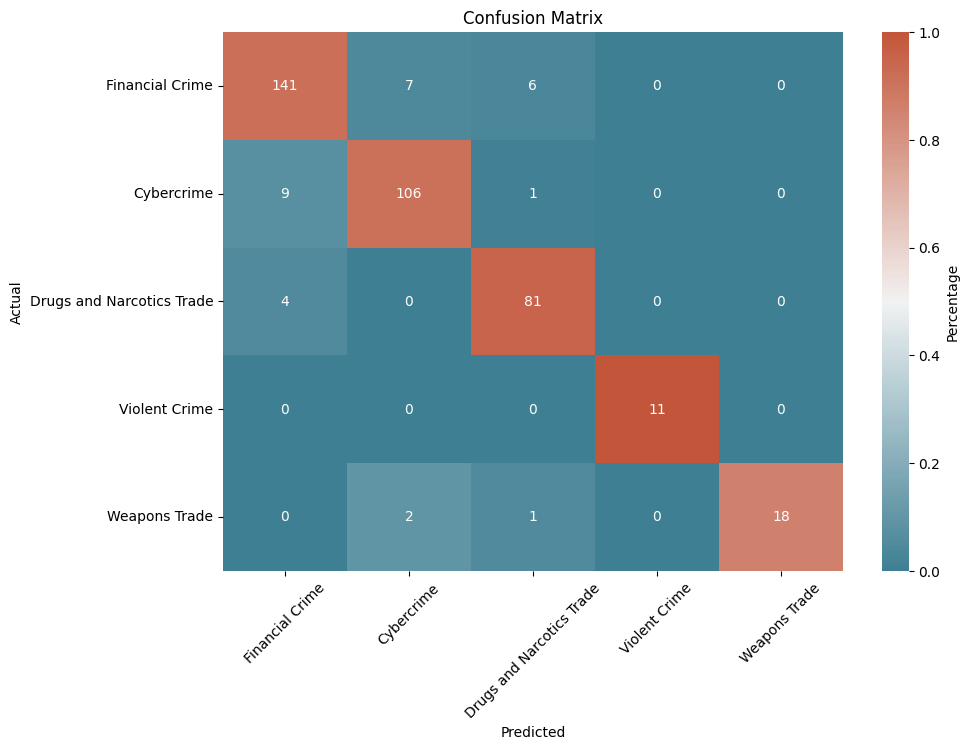

In [38]:
evaluate(model, df_test, mode=mode, metrics=True)

In [ ]:
#Spiky graph

In [21]:
EPOCHS = 20
model = BertClassifier(dropout= 0.3)
LR = 1e-06
mode = 'head'

100%|██████████| 145/145 [00:57<00:00,  2.51it/s]


Epochs: 1 | Train Loss: 0.098 | Train Balanced Accuracy: 0.290 | Val Loss: 0.092 | Val Balanced Accuracy: 0.271


100%|██████████| 145/145 [00:55<00:00,  2.62it/s]


Epochs: 2 | Train Loss: 0.093 | Train Balanced Accuracy: 0.389 | Val Loss: 0.083 | Val Balanced Accuracy: 0.337


100%|██████████| 145/145 [00:55<00:00,  2.63it/s]


Epochs: 3 | Train Loss: 0.087 | Train Balanced Accuracy: 0.477 | Val Loss: 0.073 | Val Balanced Accuracy: 0.402


100%|██████████| 145/145 [00:55<00:00,  2.62it/s]


Epochs: 4 | Train Loss: 0.081 | Train Balanced Accuracy: 0.541 | Val Loss: 0.062 | Val Balanced Accuracy: 0.529


100%|██████████| 145/145 [00:55<00:00,  2.63it/s]


Epochs: 5 | Train Loss: 0.073 | Train Balanced Accuracy: 0.619 | Val Loss: 0.052 | Val Balanced Accuracy: 0.646


100%|██████████| 145/145 [00:55<00:00,  2.62it/s]


Epochs: 6 | Train Loss: 0.066 | Train Balanced Accuracy: 0.688 | Val Loss: 0.044 | Val Balanced Accuracy: 0.863


100%|██████████| 145/145 [00:55<00:00,  2.62it/s]


Epochs: 7 | Train Loss: 0.057 | Train Balanced Accuracy: 0.782 | Val Loss: 0.037 | Val Balanced Accuracy: 0.910


100%|██████████| 145/145 [00:55<00:00,  2.63it/s]


Epochs: 8 | Train Loss: 0.048 | Train Balanced Accuracy: 0.842 | Val Loss: 0.032 | Val Balanced Accuracy: 0.914


100%|██████████| 145/145 [00:55<00:00,  2.62it/s]


Epochs: 9 | Train Loss: 0.040 | Train Balanced Accuracy: 0.867 | Val Loss: 0.029 | Val Balanced Accuracy: 0.913


100%|██████████| 145/145 [00:55<00:00,  2.63it/s]


Epochs: 10 | Train Loss: 0.036 | Train Balanced Accuracy: 0.875 | Val Loss: 0.026 | Val Balanced Accuracy: 0.916


100%|██████████| 145/145 [00:55<00:00,  2.62it/s]


Epochs: 11 | Train Loss: 0.032 | Train Balanced Accuracy: 0.888 | Val Loss: 0.024 | Val Balanced Accuracy: 0.919


100%|██████████| 145/145 [00:55<00:00,  2.62it/s]


Epochs: 12 | Train Loss: 0.029 | Train Balanced Accuracy: 0.899 | Val Loss: 0.023 | Val Balanced Accuracy: 0.922


100%|██████████| 145/145 [00:55<00:00,  2.63it/s]


Epochs: 13 | Train Loss: 0.027 | Train Balanced Accuracy: 0.904 | Val Loss: 0.022 | Val Balanced Accuracy: 0.927


100%|██████████| 145/145 [00:55<00:00,  2.63it/s]


Epochs: 14 | Train Loss: 0.026 | Train Balanced Accuracy: 0.908 | Val Loss: 0.021 | Val Balanced Accuracy: 0.922


100%|██████████| 145/145 [00:55<00:00,  2.64it/s]


Epochs: 15 | Train Loss: 0.024 | Train Balanced Accuracy: 0.912 | Val Loss: 0.021 | Val Balanced Accuracy: 0.930


100%|██████████| 145/145 [00:55<00:00,  2.62it/s]


Epochs: 16 | Train Loss: 0.023 | Train Balanced Accuracy: 0.921 | Val Loss: 0.019 | Val Balanced Accuracy: 0.928


100%|██████████| 145/145 [00:55<00:00,  2.62it/s]


Epochs: 17 | Train Loss: 0.021 | Train Balanced Accuracy: 0.923 | Val Loss: 0.019 | Val Balanced Accuracy: 0.931


100%|██████████| 145/145 [00:54<00:00,  2.64it/s]


Epochs: 18 | Train Loss: 0.020 | Train Balanced Accuracy: 0.927 | Val Loss: 0.018 | Val Balanced Accuracy: 0.933


100%|██████████| 145/145 [00:55<00:00,  2.63it/s]


Epochs: 19 | Train Loss: 0.019 | Train Balanced Accuracy: 0.931 | Val Loss: 0.018 | Val Balanced Accuracy: 0.933


100%|██████████| 145/145 [00:55<00:00,  2.62it/s]


Epochs: 20 | Train Loss: 0.018 | Train Balanced Accuracy: 0.936 | Val Loss: 0.018 | Val Balanced Accuracy: 0.934


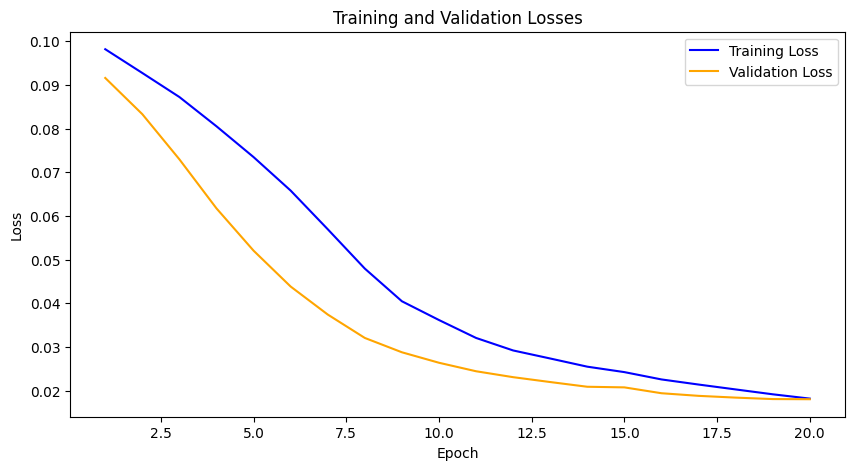

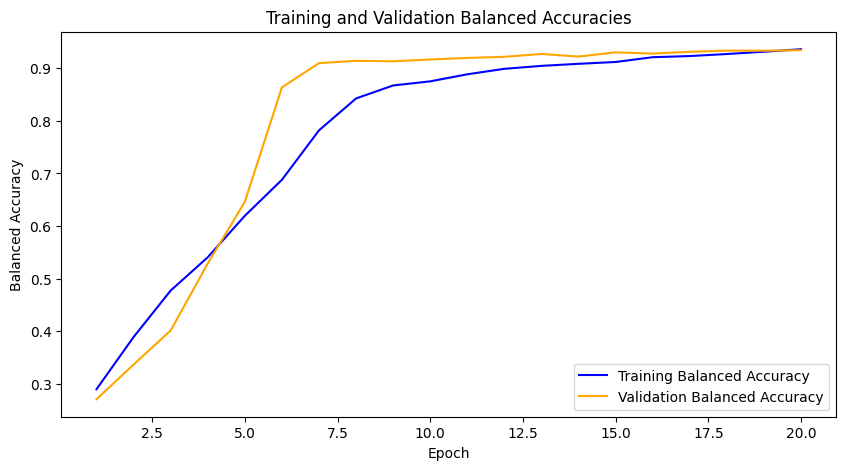

In [22]:
train(model, df_aug_train, df_val, LR, EPOCHS, mode=mode, plot_graphs=True, early_stop=False, print_epochs=True)

Quantized model

In [39]:
augmented_train_quant = pd.read_csv('data/augmented_train_quant.csv', index_col=0)
df_aug_train_quant = pd.concat([augmented_train_quant, df_train[['text', 'snapshot_id', 'label']]], ignore_index=True)
df_aug_train_quant['text'] = df_aug_train_quant['text'].apply(lambda x: x.lower())

In [40]:
augmented_trainval_quant = pd.read_csv('data/augmented_trainval_quant.csv', index_col=0)
df_aug_trainval_quant = pd.concat([augmented_trainval_quant, df_trainval[['text', 'snapshot_id', 'label']]], ignore_index=True)
df_aug_trainval_quant['text'] = df_aug_trainval_quant['text'].apply(lambda x: x.lower())

In [41]:
EPOCHS = 10
model = BertClassifier(dropout= 0.3)
LR = 4e-05
mode = 'head'

  0%|          | 0/145 [00:00<?, ?it/s]

100%|██████████| 145/145 [00:56<00:00,  2.59it/s]


Epochs: 1 | Train Loss: 0.056 | Train Balanced Accuracy: 0.667 | Val Loss: 0.022 | Val Balanced Accuracy: 0.926


100%|██████████| 145/145 [00:56<00:00,  2.59it/s]


Epochs: 2 | Train Loss: 0.024 | Train Balanced Accuracy: 0.894 | Val Loss: 0.020 | Val Balanced Accuracy: 0.918


100%|██████████| 145/145 [00:56<00:00,  2.58it/s]


Epochs: 3 | Train Loss: 0.015 | Train Balanced Accuracy: 0.932 | Val Loss: 0.019 | Val Balanced Accuracy: 0.930


100%|██████████| 145/145 [00:56<00:00,  2.59it/s]


Epochs: 4 | Train Loss: 0.012 | Train Balanced Accuracy: 0.952 | Val Loss: 0.017 | Val Balanced Accuracy: 0.939


100%|██████████| 145/145 [00:56<00:00,  2.57it/s]


Epochs: 5 | Train Loss: 0.009 | Train Balanced Accuracy: 0.963 | Val Loss: 0.018 | Val Balanced Accuracy: 0.943


100%|██████████| 145/145 [00:56<00:00,  2.59it/s]


Epochs: 6 | Train Loss: 0.008 | Train Balanced Accuracy: 0.972 | Val Loss: 0.018 | Val Balanced Accuracy: 0.942


100%|██████████| 145/145 [00:56<00:00,  2.58it/s]


Epochs: 7 | Train Loss: 0.007 | Train Balanced Accuracy: 0.971 | Val Loss: 0.016 | Val Balanced Accuracy: 0.943


100%|██████████| 145/145 [00:56<00:00,  2.57it/s]


Epochs: 8 | Train Loss: 0.005 | Train Balanced Accuracy: 0.983 | Val Loss: 0.016 | Val Balanced Accuracy: 0.947


100%|██████████| 145/145 [00:56<00:00,  2.59it/s]


Epochs: 9 | Train Loss: 0.003 | Train Balanced Accuracy: 0.989 | Val Loss: 0.017 | Val Balanced Accuracy: 0.939


100%|██████████| 145/145 [00:55<00:00,  2.59it/s]


Epochs: 10 | Train Loss: 0.003 | Train Balanced Accuracy: 0.989 | Val Loss: 0.023 | Val Balanced Accuracy: 0.940


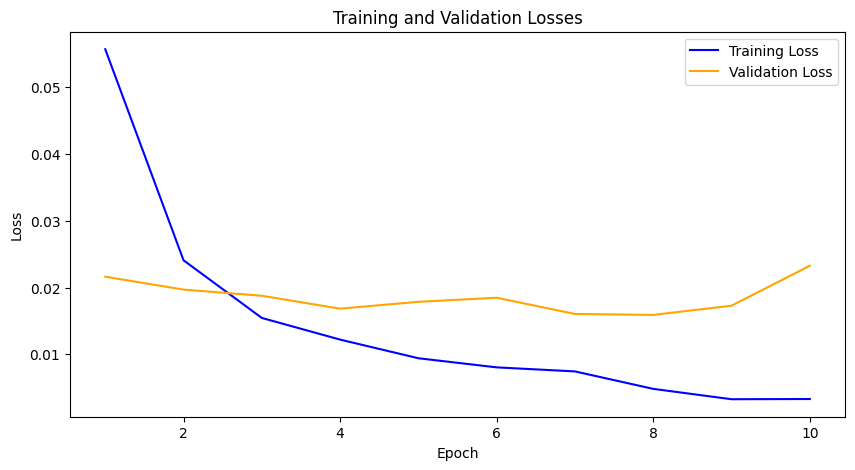

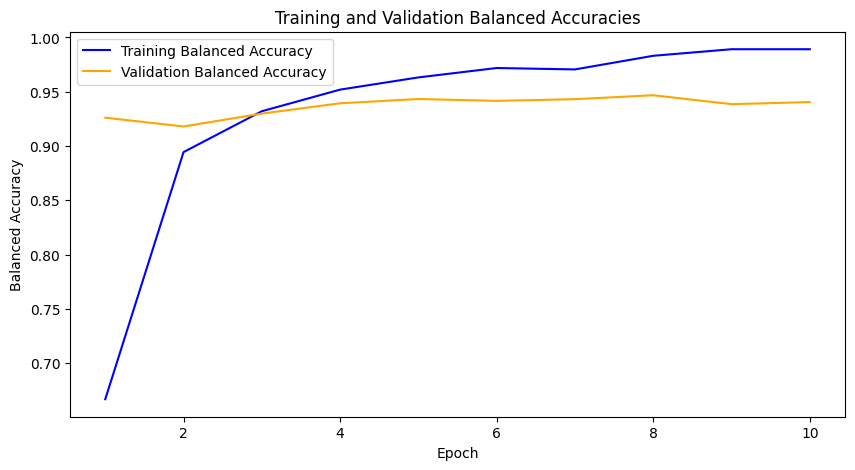

In [42]:
train(model, df_aug_train_quant, df_val, LR, EPOCHS, mode=mode, early_stop=False, plot_graphs=True, print_epochs=True)

In [45]:
EPOCHS = 4
model = BertClassifier(dropout= 0.3)
LR = 4e-05
mode = 'head'

In [46]:
train(model, df_aug_trainval_quant, df_test, LR, EPOCHS, mode=mode, early_stop=False)

  0%|          | 0/193 [00:00<?, ?it/s]

100%|██████████| 193/193 [01:15<00:00,  2.56it/s]


Balanced Accuracy: 0.94279
F1 Score: 0.94132

Financial Crime Recall: 0.92208

Cybercrime Recall: 0.92241

Drugs and Narcotics Trade Recall: 0.96471

Violent Crime Recall: 1.00000

Weapons Trade Recall: 0.90476



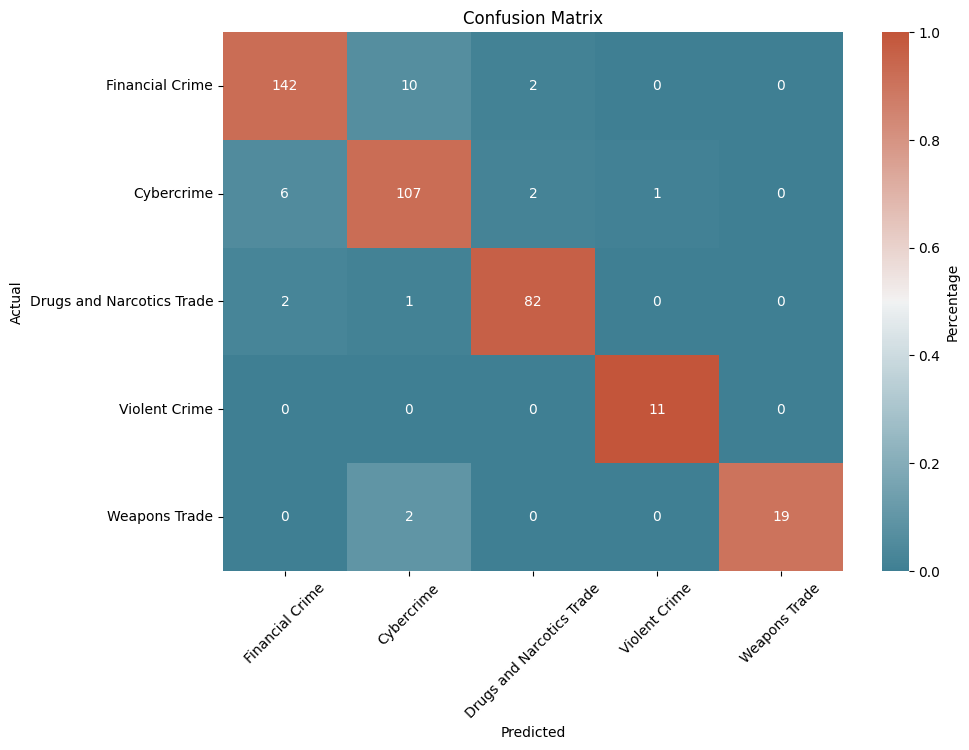

In [47]:
evaluate(model, df_test, mode=mode, metrics=True)

Chat model quantized

In [60]:
augmented_train_quant_chat = pd.read_csv('data/augmented_train_quant_chat.csv', index_col=0)
df_aug_train_quant_chat = pd.concat([augmented_train_quant_chat, df_train[['text', 'snapshot_id', 'label']]], ignore_index=True)
df_aug_train_quant_chat['text'] = df_aug_train_quant_chat['text'].apply(lambda x: x.lower())

In [61]:
augmented_trainval_quant_chat = pd.read_csv('data/augmented_trainval_quant_chat.csv', index_col=0)
df_aug_trainval_quant_chat = pd.concat([augmented_trainval_quant_chat, df_trainval[['text', 'snapshot_id', 'label']]], ignore_index=True)
df_aug_trainval_quant_chat['text'] = df_aug_trainval_quant_chat['text'].apply(lambda x: x.lower())

In [62]:
df_aug_train_quant_chat.groupby('label').count()

,text,snapshot_id
label,,
Cybercrime,462,462
Drugs and Narcotics Trade,462,462
Financial Crime,462,462
Violent Crime,462,462
Weapons Trade,462,462


In [63]:
df_aug_trainval_quant_chat.groupby('label').count()

,text,snapshot_id
label,,
Cybercrime,617,617
Drugs and Narcotics Trade,617,617
Financial Crime,617,617
Violent Crime,617,617
Weapons Trade,617,617


In [71]:
EPOCHS = 10
model = BertClassifier(dropout= 0.3)
LR = 4e-05
mode = 'head'

  0%|          | 0/145 [00:00<?, ?it/s]

100%|██████████| 145/145 [00:55<00:00,  2.61it/s]


Epochs: 1 | Train Loss: 0.035 | Train Balanced Accuracy: 0.829 | Val Loss: 0.019 | Val Balanced Accuracy: 0.927


100%|██████████| 145/145 [00:55<00:00,  2.61it/s]


Epochs: 2 | Train Loss: 0.014 | Train Balanced Accuracy: 0.939 | Val Loss: 0.018 | Val Balanced Accuracy: 0.939


100%|██████████| 145/145 [00:55<00:00,  2.61it/s]


Epochs: 3 | Train Loss: 0.008 | Train Balanced Accuracy: 0.968 | Val Loss: 0.016 | Val Balanced Accuracy: 0.943


100%|██████████| 145/145 [00:55<00:00,  2.61it/s]


Epochs: 4 | Train Loss: 0.007 | Train Balanced Accuracy: 0.971 | Val Loss: 0.018 | Val Balanced Accuracy: 0.929


100%|██████████| 145/145 [00:55<00:00,  2.61it/s]


Epochs: 5 | Train Loss: 0.006 | Train Balanced Accuracy: 0.976 | Val Loss: 0.018 | Val Balanced Accuracy: 0.908


100%|██████████| 145/145 [00:55<00:00,  2.61it/s]


Epochs: 6 | Train Loss: 0.005 | Train Balanced Accuracy: 0.977 | Val Loss: 0.019 | Val Balanced Accuracy: 0.943


100%|██████████| 145/145 [00:55<00:00,  2.60it/s]


Epochs: 7 | Train Loss: 0.003 | Train Balanced Accuracy: 0.988 | Val Loss: 0.026 | Val Balanced Accuracy: 0.931


100%|██████████| 145/145 [00:55<00:00,  2.61it/s]


Epochs: 8 | Train Loss: 0.004 | Train Balanced Accuracy: 0.987 | Val Loss: 0.020 | Val Balanced Accuracy: 0.948


100%|██████████| 145/145 [00:55<00:00,  2.60it/s]


Epochs: 9 | Train Loss: 0.002 | Train Balanced Accuracy: 0.993 | Val Loss: 0.020 | Val Balanced Accuracy: 0.945


100%|██████████| 145/145 [00:55<00:00,  2.59it/s]


Epochs: 10 | Train Loss: 0.002 | Train Balanced Accuracy: 0.994 | Val Loss: 0.023 | Val Balanced Accuracy: 0.942


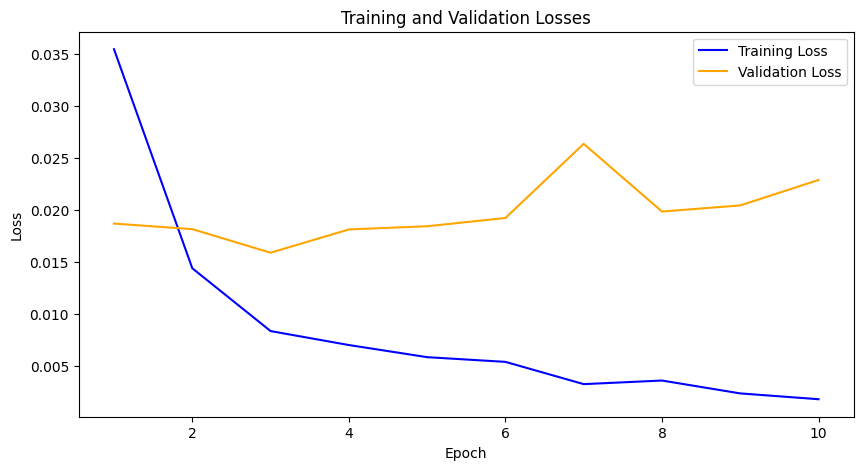

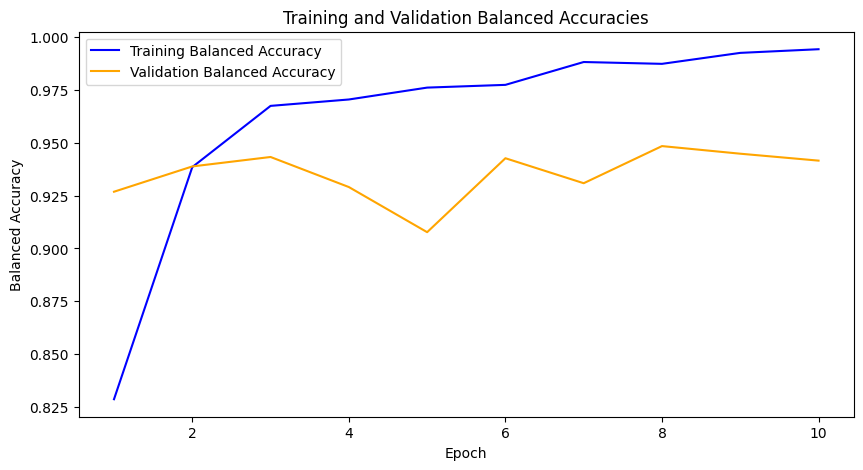

In [72]:
train(model, df_aug_train_quant_chat, df_val, LR, EPOCHS, mode=mode, early_stop=False, plot_graphs=True, print_epochs=True)

In [17]:
EPOCHS = 3
model = BertClassifier(dropout= 0.3)
LR = 4e-05
mode = 'head'

In [18]:
train(model, df_aug_trainval_quant_chat, df_test, LR, EPOCHS, mode=mode, early_stop=False)

  0%|          | 0/193 [00:00<?, ?it/s]

100%|██████████| 193/193 [01:14<00:00,  2.59it/s]


Balanced Accuracy: 0.95273
F1 Score: 0.96108

Financial Crime Recall: 0.95455

Cybercrime Recall: 0.93966

Drugs and Narcotics Trade Recall: 0.96471

Violent Crime Recall: 1.00000

Weapons Trade Recall: 0.90476



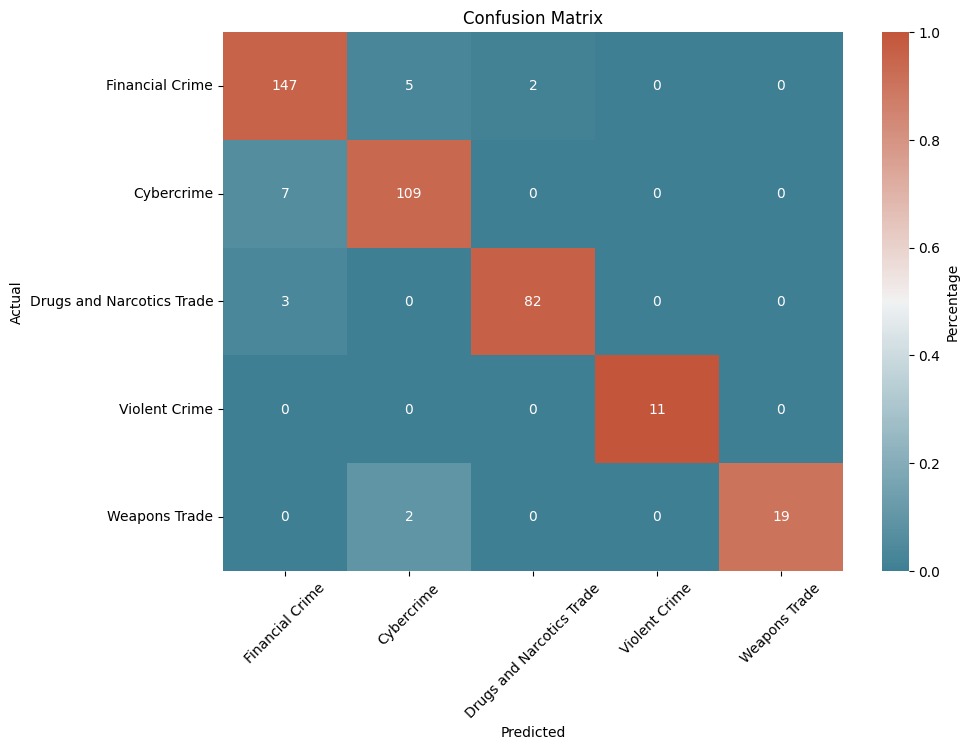

In [19]:
evaluate(model, df_test, mode=mode, metrics=True)

In [ ]:
#Spiky graphs

In [25]:
EPOCHS = 20
model = BertClassifier(dropout= 0.3)
LR = 1e-06
mode = 'head'

  0%|          | 0/145 [00:00<?, ?it/s]

100%|██████████| 145/145 [00:54<00:00,  2.64it/s]


Epochs: 1 | Train Loss: 0.098 | Train Balanced Accuracy: 0.305 | Val Loss: 0.098 | Val Balanced Accuracy: 0.294


100%|██████████| 145/145 [00:54<00:00,  2.64it/s]


Epochs: 2 | Train Loss: 0.092 | Train Balanced Accuracy: 0.405 | Val Loss: 0.089 | Val Balanced Accuracy: 0.410


100%|██████████| 145/145 [00:54<00:00,  2.64it/s]


Epochs: 3 | Train Loss: 0.083 | Train Balanced Accuracy: 0.555 | Val Loss: 0.074 | Val Balanced Accuracy: 0.630


100%|██████████| 145/145 [00:54<00:00,  2.64it/s]


Epochs: 4 | Train Loss: 0.069 | Train Balanced Accuracy: 0.742 | Val Loss: 0.059 | Val Balanced Accuracy: 0.811


100%|██████████| 145/145 [00:55<00:00,  2.64it/s]


Epochs: 5 | Train Loss: 0.056 | Train Balanced Accuracy: 0.837 | Val Loss: 0.047 | Val Balanced Accuracy: 0.902


100%|██████████| 145/145 [00:54<00:00,  2.65it/s]


Epochs: 6 | Train Loss: 0.046 | Train Balanced Accuracy: 0.875 | Val Loss: 0.038 | Val Balanced Accuracy: 0.908


100%|██████████| 145/145 [00:54<00:00,  2.64it/s]


Epochs: 7 | Train Loss: 0.037 | Train Balanced Accuracy: 0.902 | Val Loss: 0.033 | Val Balanced Accuracy: 0.914


100%|██████████| 145/145 [00:54<00:00,  2.65it/s]


Epochs: 8 | Train Loss: 0.032 | Train Balanced Accuracy: 0.914 | Val Loss: 0.029 | Val Balanced Accuracy: 0.920


100%|██████████| 145/145 [00:54<00:00,  2.64it/s]


Epochs: 9 | Train Loss: 0.027 | Train Balanced Accuracy: 0.926 | Val Loss: 0.026 | Val Balanced Accuracy: 0.930


100%|██████████| 145/145 [00:54<00:00,  2.66it/s]


Epochs: 10 | Train Loss: 0.025 | Train Balanced Accuracy: 0.927 | Val Loss: 0.024 | Val Balanced Accuracy: 0.931


100%|██████████| 145/145 [00:54<00:00,  2.64it/s]


Epochs: 11 | Train Loss: 0.022 | Train Balanced Accuracy: 0.938 | Val Loss: 0.024 | Val Balanced Accuracy: 0.933


100%|██████████| 145/145 [00:54<00:00,  2.64it/s]


Epochs: 12 | Train Loss: 0.020 | Train Balanced Accuracy: 0.938 | Val Loss: 0.022 | Val Balanced Accuracy: 0.935


100%|██████████| 145/145 [00:54<00:00,  2.65it/s]


Epochs: 13 | Train Loss: 0.018 | Train Balanced Accuracy: 0.946 | Val Loss: 0.020 | Val Balanced Accuracy: 0.933


100%|██████████| 145/145 [00:55<00:00,  2.63it/s]


Epochs: 14 | Train Loss: 0.016 | Train Balanced Accuracy: 0.949 | Val Loss: 0.020 | Val Balanced Accuracy: 0.940


100%|██████████| 145/145 [00:55<00:00,  2.64it/s]


Epochs: 15 | Train Loss: 0.015 | Train Balanced Accuracy: 0.955 | Val Loss: 0.020 | Val Balanced Accuracy: 0.938


100%|██████████| 145/145 [00:54<00:00,  2.64it/s]


Epochs: 16 | Train Loss: 0.014 | Train Balanced Accuracy: 0.961 | Val Loss: 0.019 | Val Balanced Accuracy: 0.939


100%|██████████| 145/145 [00:54<00:00,  2.64it/s]


Epochs: 17 | Train Loss: 0.013 | Train Balanced Accuracy: 0.961 | Val Loss: 0.020 | Val Balanced Accuracy: 0.934


100%|██████████| 145/145 [00:54<00:00,  2.66it/s]


Epochs: 18 | Train Loss: 0.012 | Train Balanced Accuracy: 0.966 | Val Loss: 0.019 | Val Balanced Accuracy: 0.935


100%|██████████| 145/145 [00:54<00:00,  2.66it/s]


Epochs: 19 | Train Loss: 0.011 | Train Balanced Accuracy: 0.968 | Val Loss: 0.018 | Val Balanced Accuracy: 0.937


100%|██████████| 145/145 [00:54<00:00,  2.65it/s]


Epochs: 20 | Train Loss: 0.010 | Train Balanced Accuracy: 0.969 | Val Loss: 0.018 | Val Balanced Accuracy: 0.941


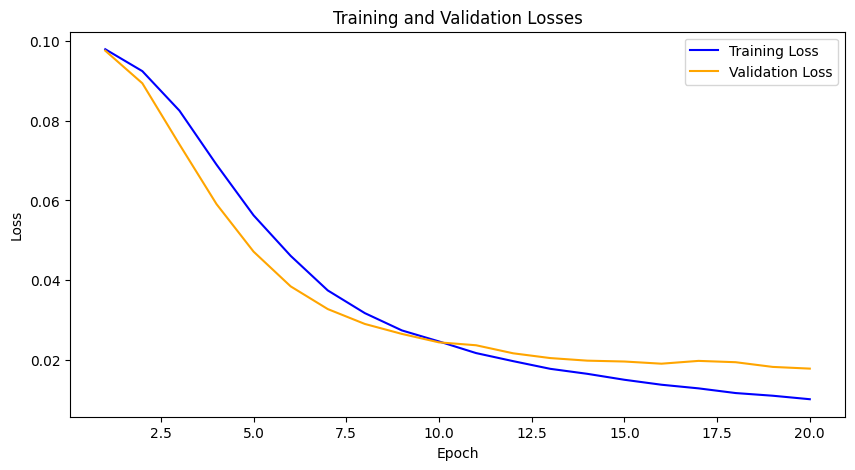

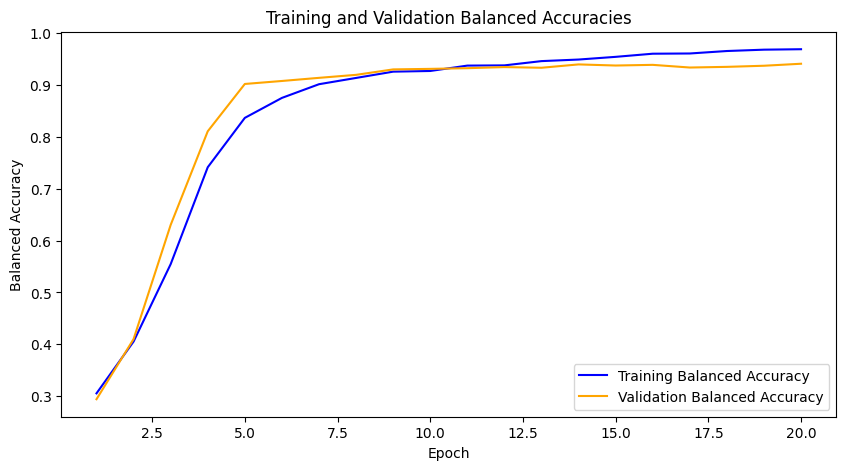

In [26]:
train(model, df_aug_train_quant_chat, df_val, LR, EPOCHS, mode=mode, early_stop=False, plot_graphs=True, print_epochs=True)

Few shot Augmentation

In [98]:
augmented_train_quant_fs = pd.read_csv('data/augmented_train_quant_fs.csv', index_col=0)
df_aug_train_quant_fs = pd.concat([augmented_train_quant_fs, df_train[['text', 'snapshot_id', 'label']]], ignore_index=True)
df_aug_train_quant_fs['text'] = df_aug_train_quant_fs['text'].apply(lambda x: x.lower())

In [99]:
augmented_trainval_quant_fs = pd.read_csv('data/augmented_trainval_quant_fs.csv', index_col=0)
df_aug_trainval_quant_fs = pd.concat([augmented_trainval_quant_fs, df_trainval[['text', 'snapshot_id', 'label']]], ignore_index=True)
df_aug_trainval_quant_fs['text'] = df_aug_trainval_quant_fs['text'].apply(lambda x: x.lower())

In [100]:
df_aug_train_quant_fs.groupby('label').count()

,text,snapshot_id
label,,
Cybercrime,462,462
Drugs and Narcotics Trade,462,462
Financial Crime,462,462
Violent Crime,462,462
Weapons Trade,462,462


In [101]:
df_aug_trainval_quant_fs.groupby('label').count()

,text,snapshot_id
label,,
Cybercrime,617,617
Drugs and Narcotics Trade,617,617
Financial Crime,617,617
Violent Crime,617,617
Weapons Trade,617,617


In [107]:
EPOCHS = 10
model = BertClassifier(dropout= 0.3)
LR = 4e-05
mode = 'head'

  0%|          | 0/145 [00:00<?, ?it/s]

100%|██████████| 145/145 [00:56<00:00,  2.57it/s]


Epochs: 1 | Train Loss: 0.055 | Train Balanced Accuracy: 0.687 | Val Loss: 0.018 | Val Balanced Accuracy: 0.935


100%|██████████| 145/145 [00:56<00:00,  2.58it/s]


Epochs: 2 | Train Loss: 0.029 | Train Balanced Accuracy: 0.858 | Val Loss: 0.018 | Val Balanced Accuracy: 0.940


100%|██████████| 145/145 [00:56<00:00,  2.58it/s]


Epochs: 3 | Train Loss: 0.019 | Train Balanced Accuracy: 0.913 | Val Loss: 0.016 | Val Balanced Accuracy: 0.940


100%|██████████| 145/145 [00:56<00:00,  2.58it/s]


Epochs: 4 | Train Loss: 0.011 | Train Balanced Accuracy: 0.955 | Val Loss: 0.024 | Val Balanced Accuracy: 0.918


100%|██████████| 145/145 [00:56<00:00,  2.56it/s]


Epochs: 5 | Train Loss: 0.009 | Train Balanced Accuracy: 0.960 | Val Loss: 0.021 | Val Balanced Accuracy: 0.932


100%|██████████| 145/145 [00:56<00:00,  2.58it/s]


Epochs: 6 | Train Loss: 0.007 | Train Balanced Accuracy: 0.970 | Val Loss: 0.030 | Val Balanced Accuracy: 0.904


100%|██████████| 145/145 [00:56<00:00,  2.55it/s]


Epochs: 7 | Train Loss: 0.005 | Train Balanced Accuracy: 0.978 | Val Loss: 0.019 | Val Balanced Accuracy: 0.942


100%|██████████| 145/145 [00:56<00:00,  2.58it/s]


Epochs: 8 | Train Loss: 0.003 | Train Balanced Accuracy: 0.987 | Val Loss: 0.025 | Val Balanced Accuracy: 0.926


100%|██████████| 145/145 [00:55<00:00,  2.59it/s]


Epochs: 9 | Train Loss: 0.002 | Train Balanced Accuracy: 0.993 | Val Loss: 0.025 | Val Balanced Accuracy: 0.922


100%|██████████| 145/145 [00:56<00:00,  2.59it/s]


Epochs: 10 | Train Loss: 0.003 | Train Balanced Accuracy: 0.991 | Val Loss: 0.024 | Val Balanced Accuracy: 0.928


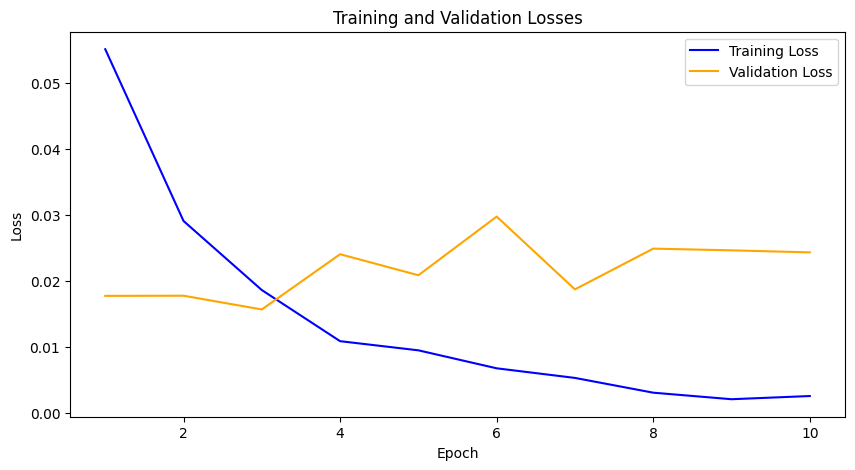

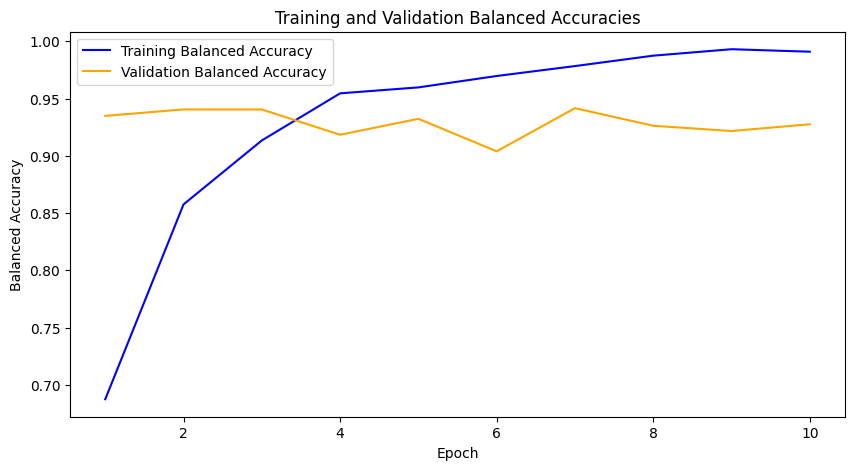

In [108]:
train(model, df_aug_train_quant_fs, df_val, LR, EPOCHS, mode=mode, early_stop=False, plot_graphs=True, print_epochs=True)

In [112]:
EPOCHS = 3
model = BertClassifier(dropout= 0.3)
LR = 4e-05
mode = 'head'

In [113]:
train(model, df_aug_trainval_quant_fs, df_test, LR, EPOCHS, mode=mode, early_stop=False)

  0%|          | 0/193 [00:00<?, ?it/s]

100%|██████████| 193/193 [01:15<00:00,  2.57it/s]


Balanced Accuracy: 0.93306
F1 Score: 0.94301

Financial Crime Recall: 0.91558

Cybercrime Recall: 0.93966

Drugs and Narcotics Trade Recall: 0.95294

Violent Crime Recall: 1.00000

Weapons Trade Recall: 0.85714



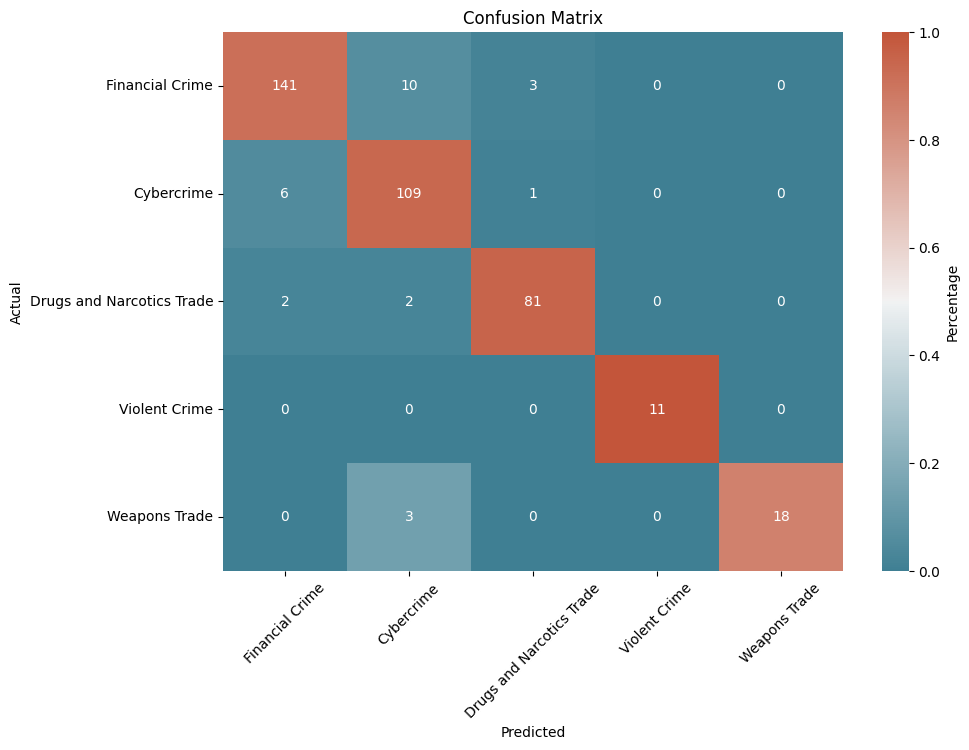

In [114]:
evaluate(model, df_test, mode=mode, metrics=True)#, save_pred=True)

In [ ]:
#Spiky graph

In [30]:
EPOCHS = 20
model = BertClassifier(dropout= 0.3)
LR = 1e-06
mode = 'head'

100%|██████████| 145/145 [00:55<00:00,  2.61it/s]


Epochs: 1 | Train Loss: 0.099 | Train Balanced Accuracy: 0.272 | Val Loss: 0.097 | Val Balanced Accuracy: 0.251


100%|██████████| 145/145 [00:55<00:00,  2.62it/s]


Epochs: 2 | Train Loss: 0.094 | Train Balanced Accuracy: 0.358 | Val Loss: 0.090 | Val Balanced Accuracy: 0.462


100%|██████████| 145/145 [00:55<00:00,  2.61it/s]


Epochs: 3 | Train Loss: 0.087 | Train Balanced Accuracy: 0.438 | Val Loss: 0.076 | Val Balanced Accuracy: 0.695


100%|██████████| 145/145 [00:55<00:00,  2.61it/s]


Epochs: 4 | Train Loss: 0.078 | Train Balanced Accuracy: 0.574 | Val Loss: 0.059 | Val Balanced Accuracy: 0.860


100%|██████████| 145/145 [00:55<00:00,  2.61it/s]


Epochs: 5 | Train Loss: 0.069 | Train Balanced Accuracy: 0.681 | Val Loss: 0.047 | Val Balanced Accuracy: 0.909


100%|██████████| 145/145 [00:55<00:00,  2.61it/s]


Epochs: 6 | Train Loss: 0.060 | Train Balanced Accuracy: 0.744 | Val Loss: 0.040 | Val Balanced Accuracy: 0.909


100%|██████████| 145/145 [00:55<00:00,  2.60it/s]


Epochs: 7 | Train Loss: 0.054 | Train Balanced Accuracy: 0.778 | Val Loss: 0.035 | Val Balanced Accuracy: 0.910


100%|██████████| 145/145 [00:55<00:00,  2.62it/s]


Epochs: 8 | Train Loss: 0.049 | Train Balanced Accuracy: 0.803 | Val Loss: 0.031 | Val Balanced Accuracy: 0.920


100%|██████████| 145/145 [00:55<00:00,  2.61it/s]


Epochs: 9 | Train Loss: 0.045 | Train Balanced Accuracy: 0.818 | Val Loss: 0.028 | Val Balanced Accuracy: 0.917


100%|██████████| 145/145 [00:55<00:00,  2.61it/s]


Epochs: 10 | Train Loss: 0.042 | Train Balanced Accuracy: 0.824 | Val Loss: 0.026 | Val Balanced Accuracy: 0.925


100%|██████████| 145/145 [00:55<00:00,  2.61it/s]


Epochs: 11 | Train Loss: 0.039 | Train Balanced Accuracy: 0.839 | Val Loss: 0.025 | Val Balanced Accuracy: 0.926


100%|██████████| 145/145 [00:55<00:00,  2.61it/s]


Epochs: 12 | Train Loss: 0.037 | Train Balanced Accuracy: 0.843 | Val Loss: 0.024 | Val Balanced Accuracy: 0.923


100%|██████████| 145/145 [00:55<00:00,  2.62it/s]


Epochs: 13 | Train Loss: 0.035 | Train Balanced Accuracy: 0.860 | Val Loss: 0.023 | Val Balanced Accuracy: 0.928


100%|██████████| 145/145 [00:55<00:00,  2.60it/s]


Epochs: 14 | Train Loss: 0.033 | Train Balanced Accuracy: 0.868 | Val Loss: 0.022 | Val Balanced Accuracy: 0.930


100%|██████████| 145/145 [00:55<00:00,  2.62it/s]


Epochs: 15 | Train Loss: 0.031 | Train Balanced Accuracy: 0.869 | Val Loss: 0.022 | Val Balanced Accuracy: 0.925


100%|██████████| 145/145 [00:55<00:00,  2.62it/s]


Epochs: 16 | Train Loss: 0.029 | Train Balanced Accuracy: 0.879 | Val Loss: 0.021 | Val Balanced Accuracy: 0.931


100%|██████████| 145/145 [00:56<00:00,  2.59it/s]


Epochs: 17 | Train Loss: 0.028 | Train Balanced Accuracy: 0.884 | Val Loss: 0.020 | Val Balanced Accuracy: 0.932


100%|██████████| 145/145 [00:56<00:00,  2.55it/s]


Epochs: 18 | Train Loss: 0.027 | Train Balanced Accuracy: 0.891 | Val Loss: 0.020 | Val Balanced Accuracy: 0.930


100%|██████████| 145/145 [00:56<00:00,  2.56it/s]


Epochs: 19 | Train Loss: 0.026 | Train Balanced Accuracy: 0.891 | Val Loss: 0.019 | Val Balanced Accuracy: 0.933


100%|██████████| 145/145 [00:56<00:00,  2.57it/s]


Epochs: 20 | Train Loss: 0.025 | Train Balanced Accuracy: 0.898 | Val Loss: 0.019 | Val Balanced Accuracy: 0.932


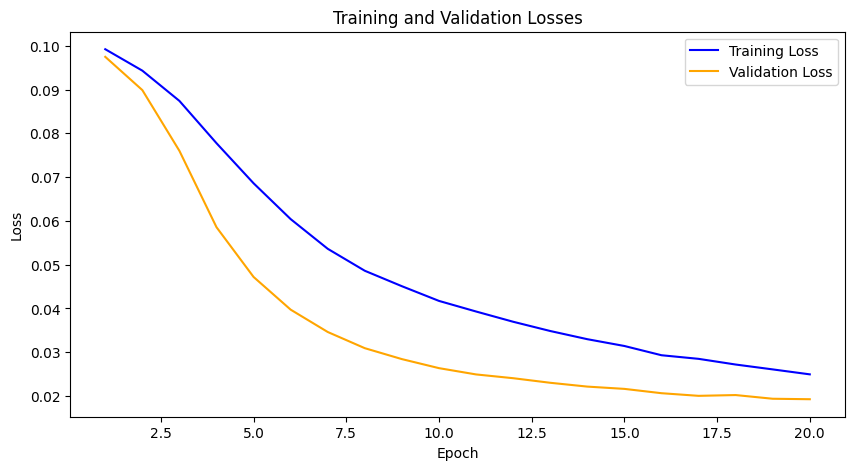

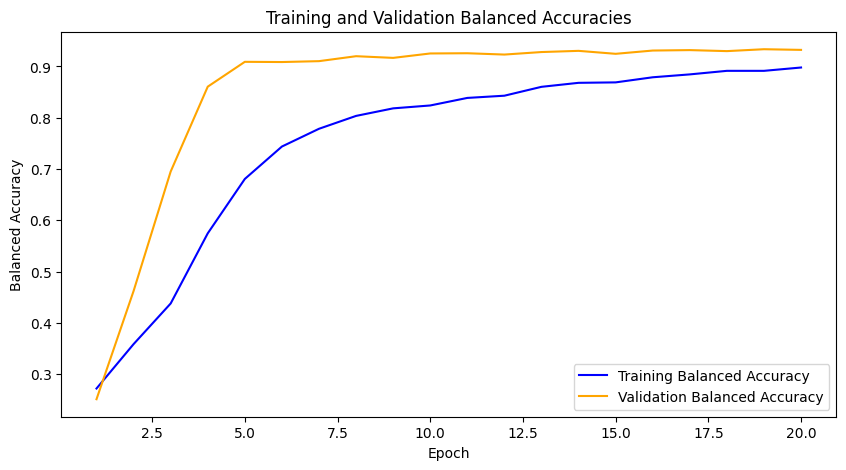

In [31]:
train(model, df_aug_train_quant_fs, df_val, LR, EPOCHS, mode=mode, early_stop=False, plot_graphs=True, print_epochs=True)